In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy.ndimage.interpolation import shift
from cases_from_deaths import ascertainment, get_jh_data
from numpy.random import normal

In [34]:
jh = get_jh_data()
jh = jh[jh.index.get_level_values(1)<=pd.Timestamp('2020-04-16')]
low=ascertainment(jh,0.004)
mid=ascertainment(jh,0.008)
high=ascertainment(jh,0.012)

In [35]:
low.loc['Brazil'][-20:]

,Deaths,Confirmed,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Recovered,Infectious
variable,,,,,,,,,,
2020-03-28,111,3904,1304.0,19.0,0.422123,0.022217,67975.725401,203237.414609,2.780849e+05,58730.273310
2020-03-29,136,4256,770.0,25.0,0.494419,0.019777,40139.040306,199259.787949,3.185520e+05,62379.822535
2020-03-30,159,4579,1031.0,23.0,0.575542,0.025024,53744.611111,207142.481885,3.611418e+05,65651.933795
2020-03-31,201,5717,1873.0,42.0,0.666582,0.015871,97636.912329,249532.265209,4.087119e+05,73328.988319
2020-04-01,240,6836,2136.0,39.0,0.768376,0.019702,111346.740381,295462.742227,4.633039e+05,84153.249034
2020-04-02,324,8044,1922.0,84.0,0.881635,0.010496,100191.214894,323934.064437,5.246352e+05,94541.839478
2020-04-03,359,9056,1546.0,35.0,1.007177,0.028776,80590.852355,331196.994487,5.906868e+05,101818.157360
2020-04-04,445,10360,1089.0,86.0,1.145988,0.013325,56768.071290,317638.935169,6.584203e+05,104410.788547
2020-04-05,486,11130,1465.0,41.0,1.298999,0.031683,76368.433829,322585.954600,7.276048e+05,106647.622050


In [36]:
# Calc initial state for susceptible, exposed, infectious, recovered, fated to die x3, died

def calc_initial_conditions(pop,erid,mort):
    return np.array([pop-erid[['Exposed','Recovered','Infectious']].sum(),
                     erid['Exposed'],
                     erid['Infectious'],
                     erid['Recovered']*(1-mort),
                     erid['Recovered']*mort*2/7,
                     erid['Recovered']*mort*2/7,
                     erid['Recovered']*mort*1/7,
                     erid['Deaths']])
    
def get_y0(dfmid,dflow,dfhigh,country,pop,morts):
    date = dfmid.loc[country].dropna(subset=['Exposed']).index.max()
    mid, low, high = (dfmid.loc[(country,date),['Exposed','Recovered','Infectious','Deaths']], 
                      dflow.loc[(country,date),['Exposed','Recovered','Infectious','Deaths']],
                      dfhigh.loc[(country,date),['Exposed','Recovered','Infectious','Deaths']])
    y0s = np.array([calc_initial_conditions(pop,mid,morts[0][0]),
                    calc_initial_conditions(pop,low,morts[1][0]),
                    calc_initial_conditions(pop,high,morts[2][0])])
    return y0s
    

# Sample a normal distribution given mean, low 95% and high 95% values

def sample_norm(df_m_l95_h95,n=100):
    scale = np.array([df_m_l95_h95[0]-df_m_l95_h95[1], df_m_l95_h95[2] - df_m_l95_h95[0]]).mean(0)/1.96
    print(df_m_l95_h95,scale)
    return normal(df_m_l95_h95[0],scale,size=(n,len(df_m_l95_h95[0])))

In [37]:
# Susceptible, Exposed, Infectious, Recovered/isolated and going to recover, Isolated and going to die, Died

def seir(y, t, beta, epsilon, mu, f,fr, n):
    s, e, i, r, preD1, preD2, preD3, d = y
    dydt = [-beta*i*s/n, 
            beta*i*s/n - epsilon * e, 
            epsilon*e - mu*i, 
            (1-f)*mu*i, 
            mu*f*i-3*fr*preD1,
            3*fr*preD1-3*fr*preD2,
            3*fr*preD2-3*fr*preD3,
            3*fr*preD3 ]
    return dydt

# Run until measures change, run again with new parameters

def sim(beta,epsilon,mu,f,y0,betap,fr = 1/17,tswitch=30,tend=250):
    n = y0.sum()
    t = np.linspace(1,tswitch,tswitch)
    t1 = np.linspace(tswitch+1,tend,tend-tswitch)
    sol0 = odeint(seir,y0,t,args=(beta,epsilon,mu,f,fr,n))
    sol1 = odeint(seir,sol0[-1],t1,args=(betap,epsilon,mu,f,fr,n))
    return np.append(sol0,sol1[1:],axis=0)

# See footnote 7 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2760158/

def beta(red, beta0 = 1.285,mu=0.5,epsilon=0.2,kappa0=np.log(1.21)):
    kappa = np.maximum(kappa0 + np.log(1-red),np.log(1-epsilon)) 
    nu = 1/epsilon + 1/mu
    te = 1/epsilon
    f = te/nu
    # This should ensure beta is >0, but for some reason I only get beta > -0.03
    return np.minimum(np.maximum(mu*(1+kappa*nu + f*(1-f)*kappa**2*nu**2),0),beta0*(1-red))

def r0_mult(red,beta0=1.285,kappa0=np.log(1.21),mu=0.5,epsilon=0.2):
    return beta(red,beta0=beta0,kappa0=kappa0,epsilon=epsilon,mu=mu)/beta0

def get_f(y0):
    return y[-2]*7/y0[0]

# Terrible approximation, but also good enough

def get_kappa0(mu):
    return np.log(1.21-(0.25-mu)*1.2)

def interp(loc,mat):
    if loc <= 0:
        alpha = max(0,-loc)
        l2 = 1
    if loc >=0:
        alpha = min(1,loc)
        l2=2
    return mat[0]*(1-alpha)+mat[l2]*alpha

In [38]:
# Events, hygiene + masks, healthcare spec, close school, 
# close businesses some, close businesses many, gatherings < 10, blanket curfew

# Best guess, low, high
# 68% not 95% intervals as I'm multiplying them together
# Reduced schools effectiveness to be in line with business closures, but boosted its upper end

CMS = np.array([[0.033,0.018,0.048],
                [0.016,0,0.036],
                [0.057,0.037,0.077],
                [0.06,0.04,0.1],
                [0.018,0.003,0.033],
                [0.019,0.004,0.034],
                [0.038,0.02,0.055],
                [0.044,0.025,0.064]])

cms_li = (1-CMS[:2]).prod(0)
cms_mi = (1-CMS[:5]).prod(0)
cms_hi = (1-CMS).prod(0)

REDS = np.array([1-cms_li,1-cms_mi,1-cms_hi])

REDS,'R0',1-r0_mult(1-cms_li),1-r0_mult(1-cms_mi),1-r0_mult(1-cms_hi)

(array([[0.048472  , 0.018     , 0.082272  ],
        [0.17172871, 0.09488416, 0.26280112],
        [0.25273511, 0.13862117, 0.37010313]]),
 'R0',
 array([0.1497417 , 0.02544483, 0.28283177]),
 array([0.60486793, 0.33106024, 0.87134151]),
 array([0.84574741, 0.49146477, 1.        ]))

In [39]:
1-r0_mult(CMS)

array([[0.08710712, 0.02544483, 0.14784608],
       [0.01715648, 0.        , 0.09933063],
       [0.18382164, 0.10339685, 0.26243185],
       [0.19573256, 0.11557041, 0.3503847 ],
       [0.02544483, 0.003     , 0.08710712],
       [0.02958324, 0.004     , 0.09118575],
       [0.1074589 , 0.03371777, 0.17585833],
       [0.1317426 , 0.05433183, 0.21154942]])

In [40]:
BETA = .76
EPSILON = 0.2

# Wild guess at time to progress from "isolated + going to die" to "dead"

FR = 1/16

# Fatalaties

Fm, Fl, Fu = 0.008,0.004,0.012

F = np.array([Fm,Fl,Fu]).reshape(-1,1)

# Best guess infectivity R0 = 3

# Low infectivity R0 = 2.3 (short infectious window might be unrealistic)

# High infectivity R0 = 3.8

MU= np.array([0.25,0.2,0.325]).reshape(-1,1)

kappa0s = np.log(np.array([1.21,1.14,1.3])).reshape(-1,1)

# 1) Best guess initial conditions, April 13 
# 2) low detection, low mortality, high infectivity 
# 3) high detection high mortality, low infectivity
# Susceptible, Exposed, Infectious, Recovered/isolated and going to recover, Isolated and going to die, Died

# y0 = np.array([[210e6 - 606e3-70e3-214e3,214e3, 70e3, 606e3*(1-Fm),606e3*Fm*2/7,606e3*Fm*2/7,606e3*Fm*1/7, 1328  ],
#                [210e6 - 1.7e6-613e3-202e3,613e3, 202e3, 1.7e6*(1-Fl),1.e6*Fl*2/7,1.e6*Fl*2/7,1.e6*Fl*1/7, 1328],
#                [210e6 - 347e3-40e3-122e3,122e3, 40e3, 347e3*(1-Fu),447e3*Fu*2/7,447e3*Fu*2/7,447e3*Fu*1/7, 1328]])



In [41]:
output = []

for reds in REDS:
    traces = dict()
    y0s = get_y0(mid,low,high,'Brazil',210e6,F)
    params_index = normal(0,0.5,size=(1000,4))
    y0_fs = np.hstack([y0s,F])
    kappa0s_mus = np.hstack([kappa0s,MU])
    params = [[interp(p[0],y0_fs),
               interp(p[1],kappa0s_mus),
               interp(p[2],reds),
               interp(p[3],REDS[0:2].mean(0))] for p in params_index]
    for i,(y0_f,kappa_mu,red,red0) in enumerate(params):
        y0, f = y0_f[:-1],y0_f[-1]
        kappa0, mu = kappa_mu
        bp = beta(red,mu=mu,kappa0=kappa0)
        b0 = beta(red0,mu=mu,kappa0=kappa0)
        s,e,inf,r,pD1,pD2,pD3,d = sim(b0,EPSILON,mu,f,y0,bp).T
        traces['S'+str(i)] = s
        traces['E'+str(i)] = e
        traces['I'+str(i)] = inf
        traces['R'+str(i)] = r
        traces['D'+str(i)] = d
    output.append(traces)

In [42]:
df_li = pd.DataFrame(output[0],index=pd.date_range(start='04/9/2020',periods=249))
a = df_li.iloc[[22,52,236],df_li.columns.str.startswith('D')]
a.median(1), a.quantile(0.05,axis=1), a.quantile(0.95,axis=1)

(2020-05-01    5.853365e+03
 2020-05-31    5.508443e+04
 2020-12-01    1.513572e+06
 dtype: float64,
 2020-05-01      5018.766605
 2020-05-31     14021.604733
 2020-12-01    828073.046999
 Name: 0.05, dtype: float64,
 2020-05-01    7.892388e+03
 2020-05-31    3.346774e+05
 2020-12-01    2.149974e+06
 Name: 0.95, dtype: float64)

In [260]:
df_mi = pd.DataFrame(output[1],index=pd.date_range(start='04/19/2020',periods=249))
a = df_mi.iloc[[12,43,226],df_li.columns.str.startswith('D')]
a.median(1), a.quantile(0.05,axis=1), a.quantile(0.95,axis=1)

(2020-05-01      6508.921658
 2020-06-01     29459.347417
 2020-12-01    218578.824911
 dtype: float64,
 2020-05-01     3734.729323
 2020-06-01    10536.562120
 2020-12-01    17780.785718
 Name: 0.05, dtype: float64,
 2020-05-01    6.872234e+03
 2020-06-01    1.074261e+05
 2020-12-01    1.498457e+06
 Name: 0.95, dtype: float64)

In [212]:
df_hi = pd.DataFrame(output[2],index=pd.date_range(start='04/19/2020',periods=249))
a = df_hi.iloc[[12,43,226],df_li.columns.str.startswith('D')]
a.median(1), a.quantile(0.05,axis=1), a.quantile(0.95,axis=1)

(2020-05-01     6170.847161
 2020-06-01    23903.649182
 2020-12-01    33493.080281
 dtype: float64,
 2020-05-01     3640.266595
 2020-06-01     9697.190658
 2020-12-01    12355.045232
 Name: 0.05, dtype: float64,
 2020-05-01      6446.190741
 2020-06-01     57900.345539
 2020-12-01    677008.662810
 Name: 0.95, dtype: float64)

In [213]:
# Testing requirements, best guess only

a = df_li.iloc[[12,43,226],df_li.columns.str.startswith('I0')|df_li.columns.str.startswith('E0')]
a.sum(1)*20*7/9

2020-05-01    2.901159e+07
2020-06-01    6.937376e+08
2020-12-01    9.638764e+00
dtype: float64

In [214]:
a = df_mi.iloc[[12,43,226],df_mi.columns.str.startswith('I0')|df_mi.columns.str.startswith('E0')]
a.sum(1)*20*7/9

2020-05-01    9.957237e+06
2020-06-01    1.607458e+07
2020-12-01    1.334848e+07
dtype: float64

In [215]:
a = df_hi.iloc[[18,49,232],df_hi.columns.str.startswith('I0')|df_hi.columns.str.startswith('E0')]
a.sum(1)*20*7/9

2020-05-07    6.022701e+06
2020-06-07    4.732514e+04
2020-12-07    1.182187e-10
dtype: float64

In [216]:
df_hi = pd.DataFrame(output[2],index=pd.date_range(start='04/12/2020',periods=249))

In [217]:
df_hi.iloc[[18,51,233],df_hi.columns.str.startswith('D')]

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D490,D491,D492,D493,D494,D495,D496,D497,D498,D499
2020-04-30,6417.448013,8992.387503,7967.902945,4899.382129,8730.948830,7082.243624,7568.754325,6359.207737,8163.261695,9280.321134,...,10402.412000,7914.062241,8397.304995,9947.607567,9228.079995,7826.353030,9552.433650,8835.668976,7800.987217,9477.480486
2020-06-02,14739.955477,31056.919548,18453.736679,27247.857191,22878.578618,18583.323166,29402.676776,51253.781295,27582.192610,75094.466886,...,69612.363338,38473.334656,21515.909681,50637.295911,32297.953465,17325.006882,41873.367600,29744.083932,29553.145935,36889.802905
2020-12-01,15696.447699,33836.377622,535301.502316,40797.363978,24500.869428,28560.818227,33537.036256,696877.110496,30825.552916,679434.737035,...,86767.782675,53343.155910,22974.348391,61824.446404,38838.939626,18327.369329,52370.367972,43825.547146,32857.853457,40570.883326


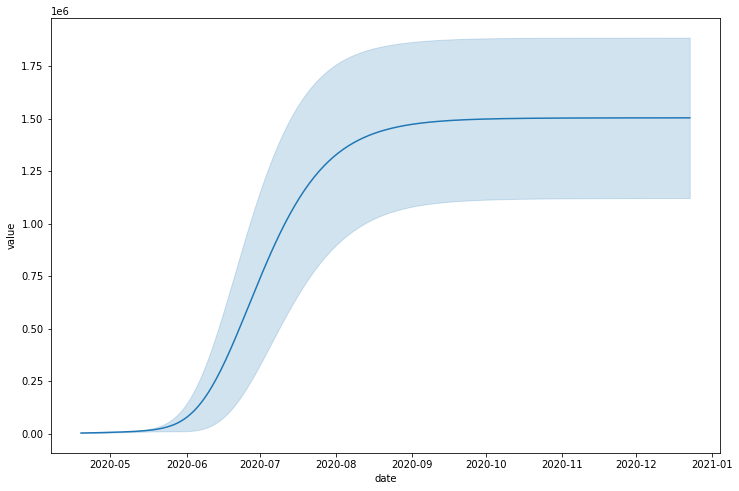

In [239]:

fig,ax = plt.subplots(figsize=(12,8))
a = df_li.loc[:,df_li.columns.str.startswith('D')].reset_index().rename(columns={'index':'date'}).melt(id_vars='date')
import seaborn as sns

sns.lineplot(data=a,x='date',y='value',ci='sd',ax=ax)

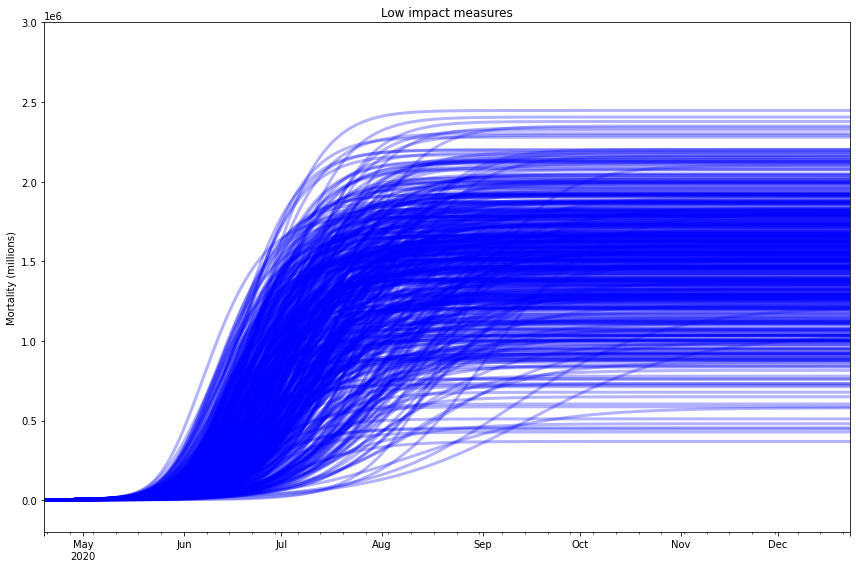

In [221]:
fig,ax = plt.subplots(figsize=(12,8))

df_li.loc[:,df_li.columns.str.startswith('D')].plot(ax=ax,legend=False,linewidth=3,alpha=0.3,color='blue')
ax.set_ylabel('Mortality (millions)')
ax.set_title('Low impact measures')
ax.set_ylim([-.2e6,3.e6])
plt.tight_layout()
# plt.savefig('low_impact_measures.png')

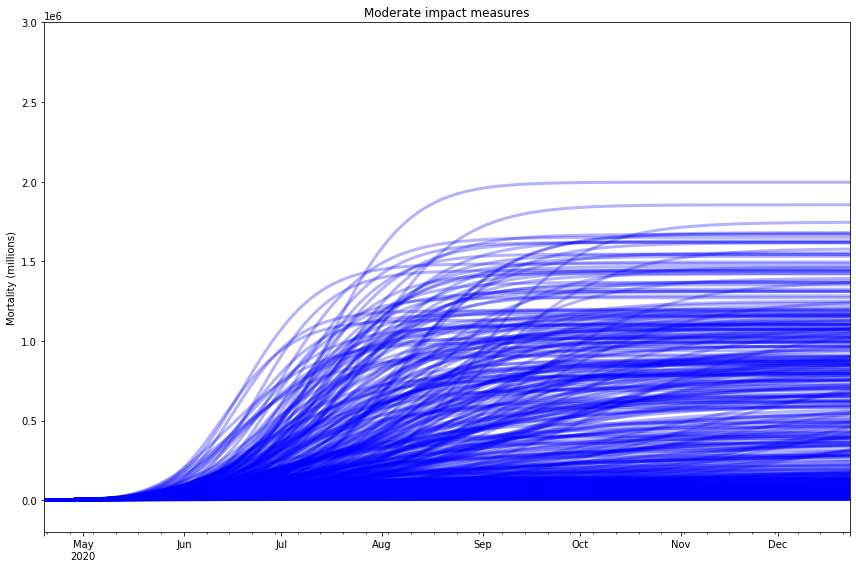

In [222]:
fig,ax = plt.subplots(figsize=(12,8))

df_mi.loc[:,df_mi.columns.str.startswith('D')].plot(ax=ax,legend=False,linewidth=3,alpha=0.3,color='blue')
ax.set_ylabel('Mortality (millions)')
ax.set_title('Moderate impact measures')
ax.set_ylim([-.2e6,3.e6])
plt.tight_layout()
# plt.savefig('med_impact_measures.png')

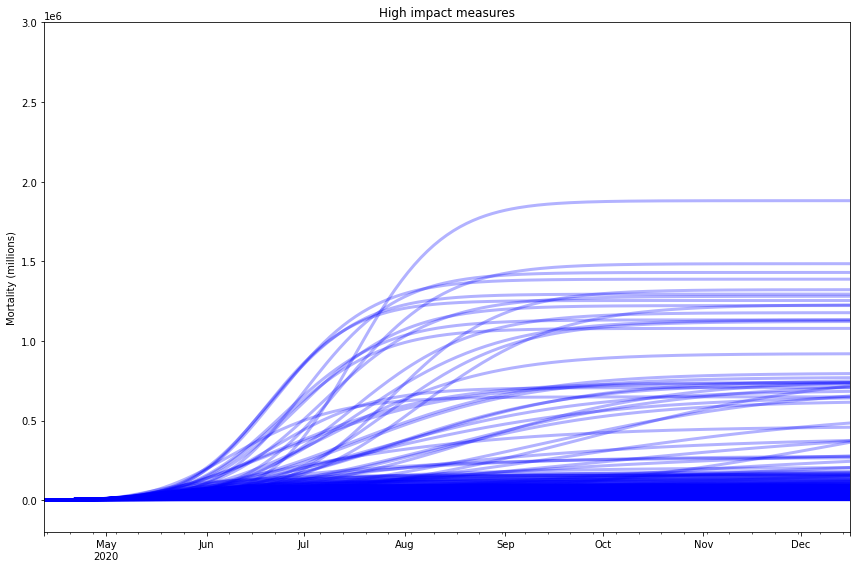

In [224]:
fig,ax = plt.subplots(figsize=(12,8))

df_hi.loc[:,df_hi.columns.str.startswith('D')].plot(ax=ax,legend=False,linewidth=3,alpha=0.3,color='blue')
ax.set_ylabel('Mortality (millions)')
ax.set_title('High impact measures')
ax.set_ylim([-.2e6,3.e6])
plt.tight_layout()
# plt.savefig('high_impact_measures.png')

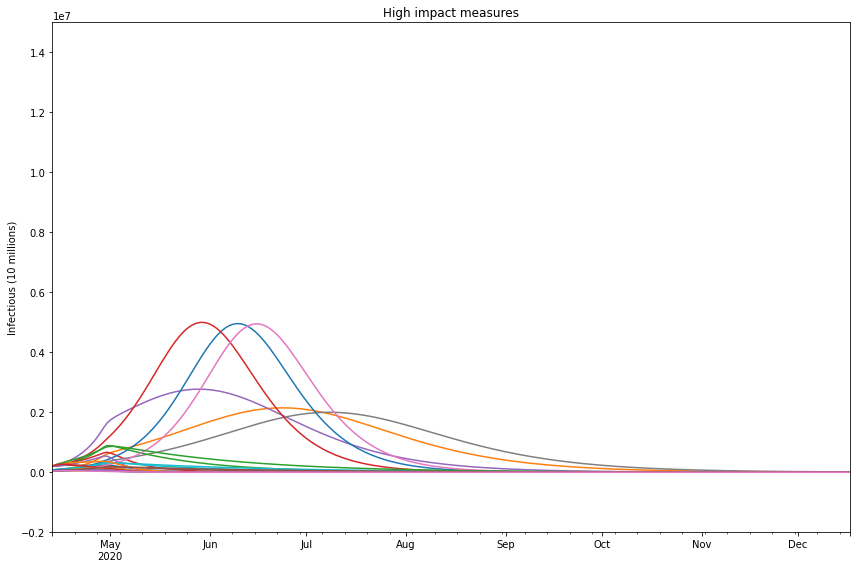

In [269]:
fig,ax = plt.subplots(figsize=(12,8))

df_hi.loc[:,df_hi.columns.str.startswith('I')].plot(ax=ax,legend=False)
ax.set_ylabel('Infectious (10 millions)')
ax.set_title('High impact measures')
ax.set_ylim([-0.2e7,1.5e7])
plt.tight_layout()

plt.savefig('high_impact_measures_inf.png')

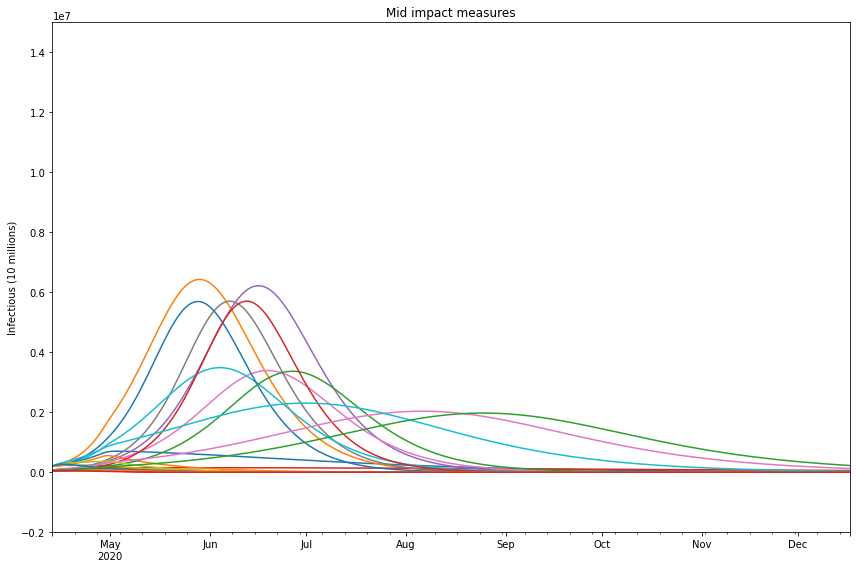

In [271]:
fig,ax = plt.subplots(figsize=(12,8))
df_mi = df_mi.rename(columns={'I0':'Best guess infectious','I1':'Low range infectious', 'I2':'High range infectious'})

df_mi.loc[:,df_mi.columns.str.startswith('I')].plot(ax=ax,legend=False)
ax.set_ylabel('Infectious (10 millions)')
ax.set_title('Mid impact measures')
ax.set_ylim([-0.2e7,1.5e7])
plt.tight_layout()
plt.savefig('mid_impact_measures_inf.png')

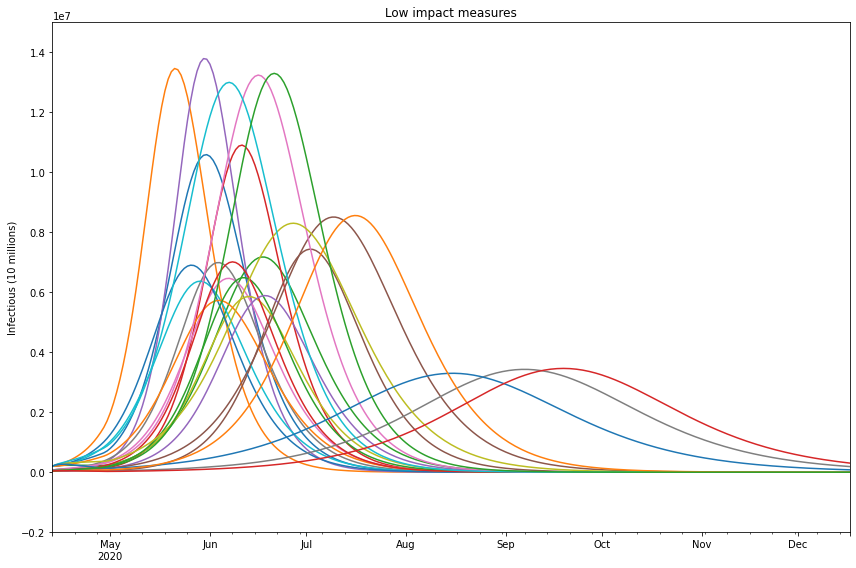

In [272]:
fig,ax = plt.subplots(figsize=(12,8))
df_li = df_li.rename(columns={'I0':'Best guess infectious','I1':'Low range infectious', 'I2':'High range infectious'})

df_li.loc[:,df_li.columns.str.startswith('I')].plot(ax=ax,legend=False)
ax.set_ylabel('Infectious (10 millions)')
ax.set_title('Low impact measures')
ax.set_ylim([-0.2e7,1.5e7])
plt.tight_layout()
plt.savefig('low_impact_measures_inf.png')

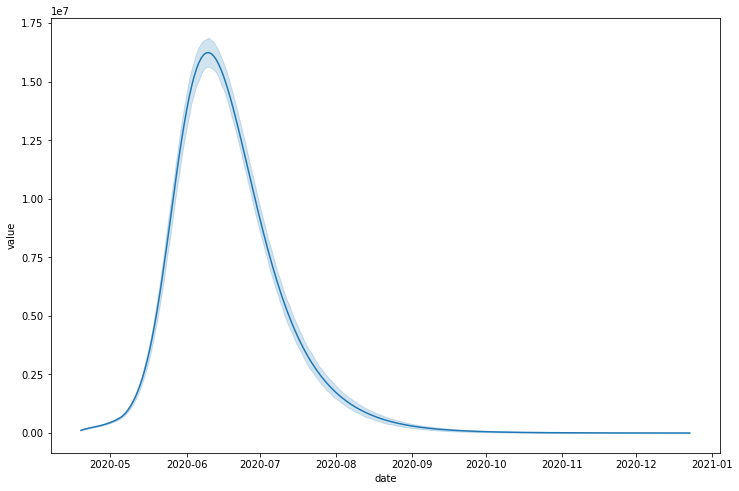

In [241]:

fig,ax = plt.subplots(figsize=(12,8))
a = df_li.loc[:,df_li.columns.str.startswith('I')].reset_index().rename(columns={'index':'date'}).melt(id_vars='date')
import seaborn as sns

sns.lineplot(data=a,x='date',y='value',ci=95,ax=ax)